[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usnistgov/AFL-agent/blob/main/docs/source/how-to/autosas_model_selection.ipynb)

# Do Model Selection with AutoSAS


## Google Colab Setup

Only uncomment and run the next cell if you are running this notebook in Google Colab or if don't already have the AFL-agent package installed.

In [ ]:
# !pip install git+https://github.com/usnistgov/AFL-agent.git

## Getting Started

First, let's import the necessary packages and load our example dataset:

In [1]:
import matplotlib.pyplot as plt

from AFL.double_agent import *
from AFL.double_agent.AutoSAS import AutoSAS


Next, let's load the example dataset. We'll subselect only part of the dataset to work with

In [2]:
from AFL.double_agent.data import example_dataset2

# Load example dataset and select the mass_fractal model
ds = example_dataset2()
ds = ds.where(ds.model.isin(['surface_fractal','mass_fractal','polymer_excl_volume']),drop=True)
ds

<xarray.Dataset> Size: 49kB
Dimensions:  (sample: 30, q: 100)
Coordinates:
  * q        (q) float64 800B 0.001 0.001072 0.00115 ... 0.8697 0.9326 1.0
Dimensions without coordinates: sample
Data variables:
    I        (sample, q) float64 24kB 5.465e+03 4.598e+03 ... 1.1 1.002
    dI       (sample, q) float64 24kB 545.9 429.3 342.6 ... 0.09923 0.09923
    model    (sample) object 240B 'surface_fractal' ... 'mass_fractal'

Let's plot the data so we can see what we're trying to fit.

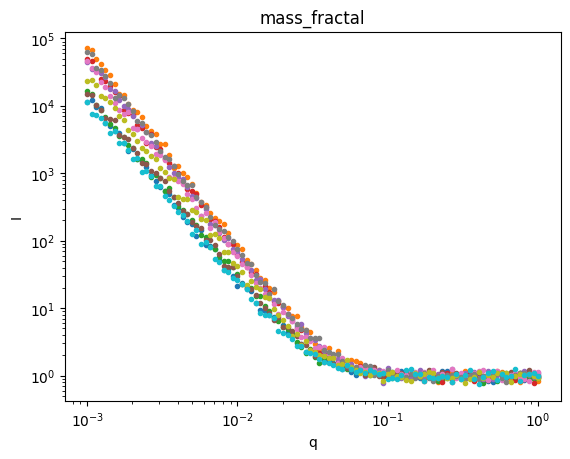

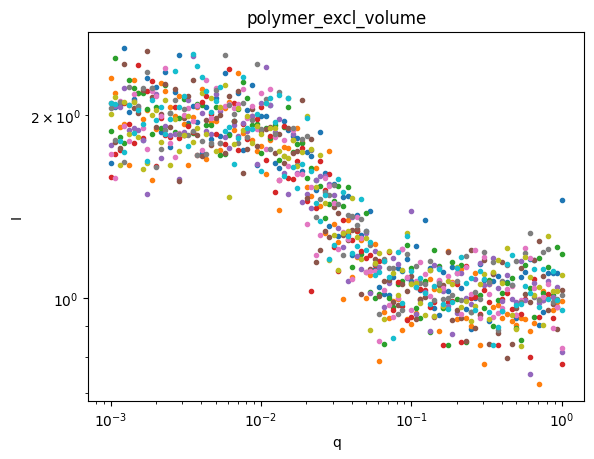

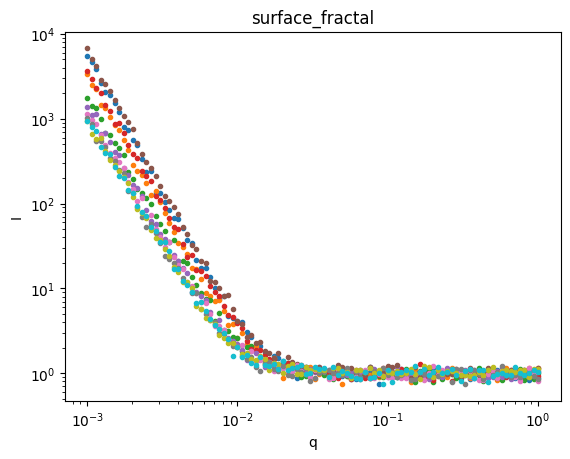

In [3]:
for model,sds in ds.groupby('model'):
    plt.figure()
    sds.I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);
    plt.title(model)

Great, we have three groups of data. Let's use AutoSAS to fit and classify this data.

## Defining the Fit

The first step to AutoSAS is to define which models we'd like to fit. Since we have three representations of data in our dataset, we'll define three models to fit it. In real, experimental scenarios, you often don't know how many structures you might encounter, so you can define as many as you'd like in the `model_input` list. 

In [20]:
model_inputs = [
    {
        "name": "surface_fractal", # your name for the model, can be anything
        "sasmodel": "power_law", # the name of the sasmodel in the sasmodels library
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "power": {"value": 4, "bounds": (3, 4)},
            "scale": {"value": 1.0, "bounds": (1e-6,1e-3)},
            "background": {"value": 1.0},
        },
    },
    {
        "name": "mass_fractal", 
        "sasmodel": "power_law", 
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "power": {"value": 4, "bounds": (1.7, 3)},
            "scale": {"value": 1.0, "bounds": (1e-4,1e-1)},
            "background": {"value": 1.0},
        },
    },
    {
        "name": "polymer", 
        "sasmodel": "polymer_excl_volume",
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "scale": {"value": 1.0, "bounds": (1e-2,1e2)},
            "rg": {"value": 60.0, "bounds": (10,150)},
            "background": {"value": 1.0},
        },
    }   
]

## Building and Executing the Pipeline


We then construct a pipeline with a single pipeline operation. We tell the operation what the data will be named in the dataset and give it the list of model inputs. 

In [43]:
with Pipeline() as autosas_pipeline1:
    AutoSAS(
        sas_variable='I',
        sas_err_variable='dI',
        q_variable = 'q',
        output_prefix='fit',
        model_inputs=model_inputs,
    )
autosas_pipeline1.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <AutoSAS>                           ['q', 'I', 'dI'] ---> ['fit_all_chisq']

Input Variables
---------------
0) q
1) I
2) dI

Output Variables
----------------
0) fit_all_chisq


Now we're ready to fit! When we run the pipeline, it will fit each of the three models in model_input to *every* measurement in the dataset. For this dataset, that means that we'll carry out 90 fits. 

In [ ]:
ds_result = autosas_pipeline1.calculate(ds)
ds_result

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 202kB
Dimensions:                    (sample: 30, q: 100, models: 3,
                                surface_fractal_params: 3,
                                mass_fractal_params: 3, polymer_params: 3,
                                fit_q_surface_fractal: 100,
                                fit_q_mass_fractal: 100, fit_q_polymer: 100)
Coordinates:
  * q                          (q) float64 800B 0.001 0.001072 ... 0.9326 1.0
  * models                     (models) <U15 180B 'surface_fractal' ... 'poly...
  * surface_fractal_params     (surface_fractal_params) <U26 312B 'surface_fr...
  * mass_fractal_params        (mass_fractal_params) <U23 276B 'mass_fractal_...
  * polymer_params             (polymer_params) <U18 216B 'polymer_scale' ......
  * fit_q_surface_fractal      (fit_q_surface_fractal) float64 800B 0.001 ......
  * fit_q_mass_fractal         (fit_q_mass_fractal) float64 800B 0.001 ... 1.0
  * fit_q_polymer              (fit_q_polymer) float64 800B 0.001 ... 1.0
Dimensions without coordinates: sample
Data variables: (12/18)
    I                          (sample, q) float64 24kB 5.465e+03 ... 1.002
    dI                         (sample, q) float64 24kB 545.9 429.3 ... 0.09923
    model                      (sample) object 240B 'surface_fractal' ... 'ma...
    sas_fit_sample             (sample) int64 240B 0 1 2 3 4 ... 25 26 27 28 29
    fit_all_chisq              (sample, models) float64 720B 1.023 ... 27.2
    probabilities              (sample, models) float64 720B 0.01182 ... 0.00...
    ...                         ...
    fit_I_surface_fractal      (sample, fit_q_surface_fractal) float64 24kB 5...
    residuals_surface_fractal  (sample, fit_q_surface_fractal) float64 24kB -...
    fit_I_mass_fractal         (sample, fit_q_mass_fractal) float64 24kB 956....
    residuals_mass_fractal     (sample, fit_q_mass_fractal) float64 24kB -8.2...
    fit_I_polymer              (sample, fit_q_polymer) float64 24kB 6.219 ......
    residuals_polymer          (sample, fit_q_polymer) float64 24kB -10.0 ......

Now, this is a large dataset. You should see 18 data variables. This includes:

1. Input data variables (`I`, `dI`, `q`, `model`, `sas_fit_sample`)
2. Fit quality metrics (`fit_all_chisq`, `probabilities`) 
3. Model parameters for each model type (`surface_fractal_params`, `mass_fractal_params`, `polymer_params`)
4. Fitted intensity curves for each model (`fit_I_surface_fractal`, `fit_I_mass_fractal`, `fit_I_polymer`)
5. Residuals for each model (`residuals_surface_fractal`, `residuals_mass_fractal`, `residuals_polymer`)
 


## Evaluating the Fit Results

Okay, now we must evaluate the quality of the fits. If the parameters of the model_inputs dialog are too constraining, then the fit might not be able to be fully optimized. 


We'll plot all three fits to a given measurement (defined by `data_index`) below and along with the residual for the fit. Vary the `data_index` in order to assess the quality of the models for different data. 

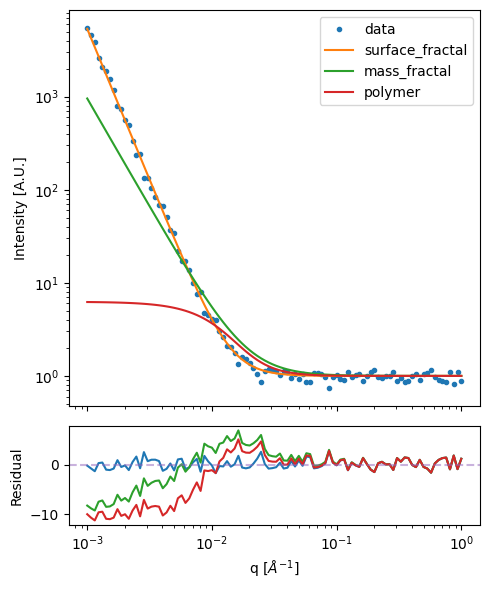

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), height_ratios=[4, 1], sharex=True)

data_index = 0

# Top plot - data and fits
ds_result.isel(sample=data_index).I.plot.line(x='q', xscale='log', yscale='log', marker='.', ls='None', label='data', ax=ax1)
ds_result.isel(sample=data_index).fit_I_surface_fractal.plot.line(x='fit_q_surface_fractal', xscale='log', yscale='log', label='surface_fractal', ax=ax1)
ds_result.isel(sample=data_index).fit_I_mass_fractal.plot.line(x='fit_q_mass_fractal', xscale='log', yscale='log', label='mass_fractal', ax=ax1)
ds_result.isel(sample=data_index).fit_I_polymer.plot.line(x='fit_q_polymer', xscale='log', yscale='log', label='polymer', ax=ax1)
ax1.legend()
ax1.set(xlabel=None,ylabel='Intensity [A.U.]')

ax1.get_lines()[0].set_color('C0')  # Keep data points as first color


# Bottom plot - residuals
ds_result.isel(sample=data_index).residuals_surface_fractal.plot(x='fit_q_surface_fractal', xscale='log',  ax=ax2)
ds_result.isel(sample=data_index).residuals_mass_fractal.plot(x='fit_q_mass_fractal', xscale='log',  ax=ax2)
ds_result.isel(sample=data_index).residuals_polymer.plot(x='fit_q_polymer', xscale='log',  ax=ax2)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.get_lines()[1].set_color('C2')  # Skip C1, use C2 for surface_fractal
ax2.get_lines()[2].set_color('C3')  # Use C3 for mass_fractal  
ax2.get_lines()[3].set_color('C4')  # Use C4 for polymer
ax2.set(xlabel='q [$\AA^{-1}$]',ylabel='Residual')

plt.tight_layout()

The residuals (differences between the model and data) provide a key way to assess the quality of the fits. A good fit should show residuals that:

1. Are randomly scattered around zero
2. Have no clear systematic trends or patterns
3. Are roughly within ±2-3 standard deviations of zero

Let's plot the residuals for the first sample to assess the quality of our surface fractal fits:


## Adding Model Selection to the Pipeline


Okay, now to the hard part. We've fit the data, but we need to assess which model is best for each measurement. AutoSAS has a number of built in model selection tools for making this decision:

1. Bayesian Information Criterion (BIC) - Balances model complexity with goodness of fit
2. Akaike Information Criterion (AIC) - Similar to BIC but penalizes complexity less
3. Probability-based selection - Uses Bayesian probability theory to calculate model likelihoods
4. Chi-squared test - Compares the goodness of fit between models

We'll use the Chi-square option for this demonstration

In [47]:
from AFL.double_agent.AutoSAS import ModelSelectBestChiSq

with Pipeline() as autosas_pipeline2:
    AutoSAS(
        sas_variable='I',
        sas_err_variable='dI',
        q_variable = 'q',
        output_prefix='fit',
        model_inputs=model_inputs,
    )

    ModelSelectBestChiSq(
        all_chisq_var='fit_all_chisq',
        model_names_var='models',
        sample_dim='sample',
        output_prefix='BestChiSq',
    )
autosas_pipeline2.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <AutoSAS>                           ['q', 'I', 'dI'] ---> ['fit_all_chisq']
1  ) <ModelSelection_BestChiSq>          ['fit_all_chisq', 'models'] ---> ['BestChiSq_labels', 'BestChiSq_label_names']

Input Variables
---------------
0) q
1) I
2) dI
3) models

Output Variables
----------------
0) BestChiSq_labels
1) BestChiSq_label_names


In [48]:
ds_result2 = autosas_pipeline2.calculate(ds_result)
ds_result2

  0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 205kB
Dimensions:                    (sample: 30, q: 100, models: 3,
                                surface_fractal_params: 3,
                                mass_fractal_params: 3, polymer_params: 3,
                                fit_q_surface_fractal: 100,
                                fit_q_mass_fractal: 100, fit_q_polymer: 100)
Coordinates:
  * q                          (q) float64 800B 0.001 0.001072 ... 0.9326 1.0
  * models                     (models) <U15 180B 'surface_fractal' ... 'poly...
  * surface_fractal_params     (surface_fractal_params) <U26 312B 'surface_fr...
  * mass_fractal_params        (mass_fractal_params) <U23 276B 'mass_fractal_...
  * polymer_params             (polymer_params) <U18 216B 'polymer_scale' ......
  * fit_q_surface_fractal      (fit_q_surface_fractal) float64 800B 0.001 ......
  * fit_q_mass_fractal         (fit_q_mass_fractal) float64 800B 0.001 ... 1.0
  * fit_q_polymer              (fit_q_polymer) float64 800B 0.001 ... 1.0
Dimensions without coordinates: sample
Data variables: (12/21)
    I                          (sample, q) float64 24kB 5.465e+03 ... 1.002
    dI                         (sample, q) float64 24kB 545.9 429.3 ... 0.09923
    model                      (sample) object 240B 'surface_fractal' ... 'ma...
    sas_fit_sample             (sample) int64 240B 0 1 2 3 4 ... 25 26 27 28 29
    fit_all_chisq              (sample, models) float64 720B 1.023 ... 27.2
    probabilities              (sample, models) float64 720B 0.01182 ... 0.00...
    ...                         ...
    residuals_mass_fractal     (sample, fit_q_mass_fractal) float64 24kB -8.2...
    fit_I_polymer              (sample, fit_q_polymer) float64 24kB 6.219 ......
    residuals_polymer          (sample, fit_q_polymer) float64 24kB -10.0 ......
    BestChiSq_labels           (sample) int64 240B 0 1 0 1 2 0 0 ... 2 1 2 1 2 1
    BestChiSq_ChiSq            (sample) float64 240B 1.023 0.9502 ... 1.086
    BestChiSq_label_names      (sample) <U15 2kB 'surface_fractal' ... 'mass_...

This dataset is similar to the one above but it has three new data variables:

1. `BestChiSq_labels` - An array of integers indicating which model had the best chi-squared value for each sample (0 = surface_fractal, 1 = mass_fractal, 2 = polymer)
2. `BestChiSq_ChiSq` - The chi-squared value for the best model for each sample
3. `BestChiSq_label_names` - The name of the best model for each sample as a string (e.g. 'surface_fractal', 'mass_fractal', 'polymer')

Let's plot the in groups based on the auto labeling

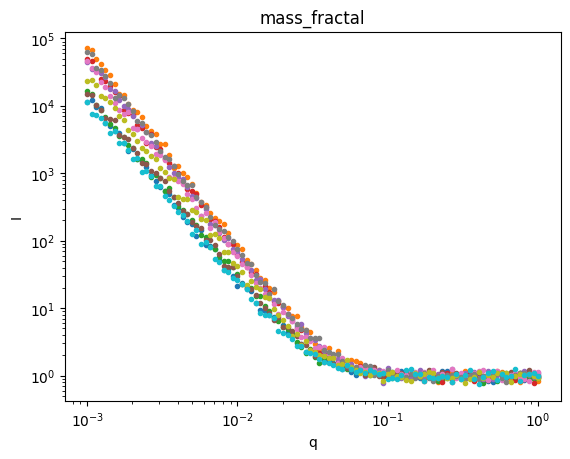

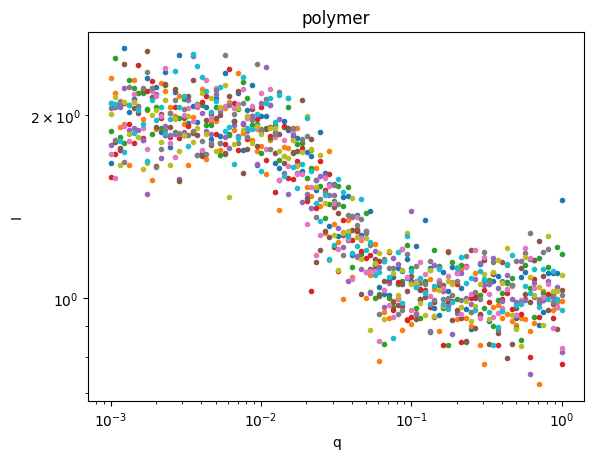

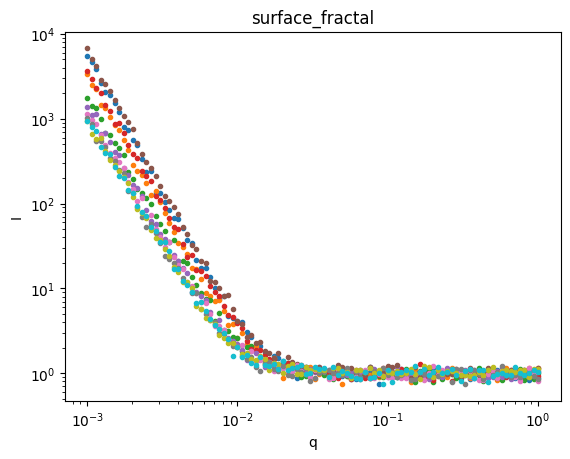

In [49]:
for model,sds in ds_result2.groupby('BestChiSq_label_names'):
    plt.figure()
    sds.I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);
    plt.title(model)

Excellent! It looks like we got a perfect separation, even between the two fractal models.

## Conclusion

 In this example, we demonstrated a complete workflow for fitting multiple SAS models to data and automatically selecting the best model based on chi-squared values. While this example used simulated data that was specifically generated to be well-separated between different model types (making the fitting and model selection relatively straightforward), it illustrates the key components and capabilities of the AutoSAS pipeline:
 
1. Fitting multiple models to the same dataset
2. Comparing fit quality across models
3. Automatically selecting the best model for each sample
 
With real experimental data, the fitting and model selection process may be more challenging due to:
- Noise and experimental uncertainties
- Samples that could be described by multiple models
- More complex scattering patterns requiring more sophisticated models
 
However, the workflow demonstrated here provides a foundation for approaching these more complex cases in a systematic way.